In [1]:
# Import packages
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from matplotlib.pylab import rcParams
import itertools
import numpy as np
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

# Preferred settings
warnings.simplefilter("ignore")


<ipython-input-1-7c1c9c0627ad>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [2]:
# Import saved data
df_TS = pd.read_csv('Data/df_TS.csv')

# Set date column to datetime object
df_TS['Date'] = pd.to_datetime(df_TS['Date'])

# Set date column as index
df_TS.set_index('Date', inplace=True)

# Prepare Data

In [4]:
# Create df of only Staten Island data, remove columns unhelpful to time series model 
df_SI = df_TS.drop(columns = ['Injuries', 'Deaths','Accidents_Bx', 'Accidents_Man', 'Accidents_Qns', 'Accidents_Bkln',
                               'Accidents_Total'])

# Only use pre-COVID data for time series modeling
df_SI = df_SI.loc[:'2020-3-13']

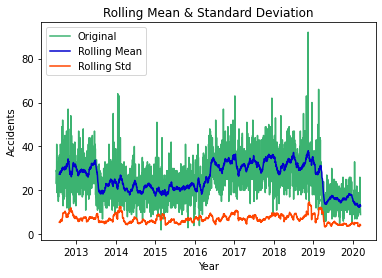

Test Statistic                   -2.474274
p-value                           0.121860
#Lags Used                       27.000000
Number of Observations Used    2783.000000
dtype: float64

In [5]:
# Visualize data, including 30-day rolling mean and standard deviation

roll_mean = df_SI['Accidents_SI'].rolling(window=30, center=False).mean()
roll_std = df_SI['Accidents_SI'].rolling(window=30, center=False).std()

plt.plot(df_SI['Accidents_SI'],color='mediumseagreen', label='Original')
plt.plot(roll_mean, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std, color='orangered', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.ylabel('Accidents')
plt.show(block=False)

# Dickey-Fuller test
test = adfuller(df_SI['Accidents_SI'][1:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Based on the above visualization and Dickey-Fuller p-value, we see that this data is not stationary. Before modeling, we will difference the data to see if it can achieve stationarity.

**Differencing**

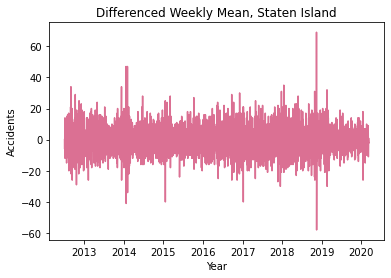

Test Statistic                -1.717901e+01
p-value                        6.665996e-30
#Lags Used                     2.600000e+01
Number of Observations Used    2.784000e+03
dtype: float64

In [7]:
# Difference data
diff_SI = df_SI['Accidents_SI'].diff()

# Plot differenced data
plt.plot(diff_SI, color='palevioletred', label='Differenced Rolling Weekly Mean')
plt.title('Differenced Weekly Mean, Staten Island')
plt.xlabel('Year')
plt.ylabel('Accidents')
plt.show(block=False)

# Dickey-Fuller test
test = adfuller(diff_SI[1:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

We see above the differencing once achieved stationarity. We therefore expect our best ARIMA models to have a d value of at least 1.

# ARIMA Models

## Baseline Model: ARIMA with no Exogenous Variables

**ACF, PACF**

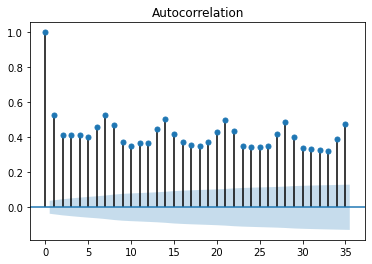

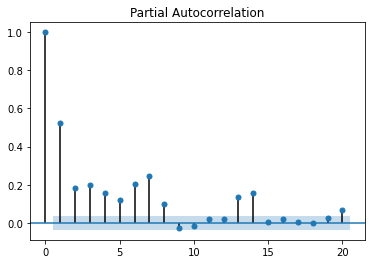

In [9]:
# ACF
plot_acf(df_SI['Accidents_SI'], alpha=.05);

# PACF
plot_pacf(df_SI['Accidents_SI'], alpha=.05, lags=20);

Based on the above ACF and PACF, when instantiating an ARIMA model, we would expect a relatively large number of MA terms due to the larger number of significant ACF points and a relatively small number of AR terms due to the small number of significant PACF points.

**Train-Test Split**

In [10]:
# Determine split point for 90%/10% train-test split
split_point = int(len(df_SI) * 0.9)
df_SI.iloc[split_point]

Accidents_SI          16
Season            Spring
Day of Week     Thursday
Weekend                0
Holiday                0
Name: 2019-06-06 00:00:00, dtype: object

In [11]:
# Train-test split
# Based on the above, 2019-06-06 will be the split point for our train and test sets

X = df_SI.index
y = df_SI['Accidents_SI']

train = df_SI.loc[:'2019-06-06']
test = df_SI.loc['2019-06-06':]

X_train, X_test = train.index , test.index
y_train, y_test = train['Accidents_SI'] , test['Accidents_SI']

**Grid Search**

In [12]:
# Determine best parameters for ARIMA model

# Define the p, d, and q parameters to take any value between 0 and 4
p = d = q = range(0,4)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Run a grid with pdq parameters calculated to see corresponding AIC scores
ans_ARIMA = []
for comb in pdq:
    try:
        mod = ARIMA(y_train, order=comb)
        output = mod.fit()
        ans_ARIMA.append([comb, output.aic])
        print('ARIMA {} : AIC Calculated ={}'.format(comb,output.aic))
    except:
        continue

ARIMA (0, 0, 0) : AIC Calculated =18540.470139196266
ARIMA (0, 0, 1) : AIC Calculated =18079.471700415423
ARIMA (0, 0, 2) : AIC Calculated =17986.655023798903
ARIMA (0, 0, 3) : AIC Calculated =17920.038672004517
ARIMA (0, 1, 0) : AIC Calculated =18670.925335438398
ARIMA (0, 1, 1) : AIC Calculated =17549.45562332418
ARIMA (0, 1, 2) : AIC Calculated =17472.789202168522
ARIMA (0, 1, 3) : AIC Calculated =17473.884929415784
ARIMA (0, 2, 0) : AIC Calculated =21222.734650427345
ARIMA (0, 2, 1) : AIC Calculated =18674.385259777107
ARIMA (0, 2, 2) : AIC Calculated =17558.100326422344
ARIMA (0, 2, 3) : AIC Calculated =17481.75812517983
ARIMA (1, 0, 0) : AIC Calculated =17904.277142178093
ARIMA (1, 0, 1) : AIC Calculated =17549.497393380832
ARIMA (1, 0, 2) : AIC Calculated =17476.18943469609
ARIMA (1, 0, 3) : AIC Calculated =17476.955153941057
ARIMA (1, 1, 0) : AIC Calculated =18290.9007134986
ARIMA (1, 1, 1) : AIC Calculated =17479.634773691047
ARIMA (1, 1, 2) : AIC Calculated =17474.10518925805

In [13]:
# Find parameters with minimal AIC value
df_AIC = pd.DataFrame(ans_ARIMA, columns=['pdq', 'aic'])
df_AIC.sort_values(by='aic', ascending=True, inplace=True)
df_AIC[:10]

,pdq,aic
37,"(3, 1, 3)",17336.948382
26,"(2, 1, 1)",17472.317724
6,"(0, 1, 2)",17472.789202
27,"(2, 1, 2)",17472.891375
35,"(3, 1, 1)",17473.653601
7,"(0, 1, 3)",17473.884929
18,"(1, 1, 2)",17474.105189
19,"(1, 1, 3)",17474.385486
32,"(3, 0, 2)",17474.780232
36,"(3, 1, 2)",17474.872290


**Narrowing Down Parameters**

Observe lowest 10 AIC score parameter values to determine best model. Make sure p values are significant, and observe RMSEs to determind best overall model.

In [14]:
for pdq in df_AIC['pdq'][:10]:
    mod = ARIMA(y_train[:-1], order=pdq)
    mod_fit = mod.fit()
    print(mod_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:         D.Accidents_SI   No. Observations:                 2530
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -8657.512
Method:                       css-mle   S.D. of innovations              7.399
Date:                Thu, 18 Feb 2021   AIC                          17331.024
Time:                        14:24:08   BIC                          17377.712
Sample:                    07-02-2012   HQIC                         17347.963
                         - 06-05-2019                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0046      0.010     -0.455      0.649      -0.024       0.015
ar.L1.D.Accidents_SI    -0.2404      0.000  -2051.942      0.000      -0.241      -0.240
ar.L2.D.Acci

                             ARIMA Model Results                              
Dep. Variable:         D.Accidents_SI   No. Observations:                 2530
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -8727.877
Method:                       css-mle   S.D. of innovations              7.617
Date:                Thu, 18 Feb 2021   AIC                          17467.755
Time:                        14:24:11   BIC                          17502.771
Sample:                    07-02-2012   HQIC                         17480.460
                         - 06-05-2019                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0045      0.011     -0.402      0.688      -0.026       0.017
ar.L1.D.Accidents_SI     0.1794      0.022      8.083      0.000       0.136       0.223
ar.L2.D.Acci

                             ARIMA Model Results                              
Dep. Variable:         D.Accidents_SI   No. Observations:                 2530
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -8727.487
Method:                       css-mle   S.D. of innovations              7.616
Date:                Thu, 18 Feb 2021   AIC                          17468.974
Time:                        14:24:15   BIC                          17509.826
Sample:                    07-02-2012   HQIC                         17483.796
                         - 06-05-2019                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0044      0.011     -0.387      0.699      -0.027       0.018
ar.L1.D.Accidents_SI     0.5018      0.233      2.156      0.031       0.046       0.958
ar.L2.D.Acci

From the above, we see that (3,0,2) is the only set of parameters with significant p-values. We will now look at the next 10 lowest AIC scores.

In [15]:
for pdq in df_AIC['pdq'][10:20]:
    mod = ARIMA(y_train[:-1], order=pdq)
    mod_fit = mod.fit()
    print(mod_fit.summary())

                              ARMA Model Results                              
Dep. Variable:           Accidents_SI   No. Observations:                 2531
Model:                     ARMA(3, 1)   Log Likelihood               -8728.562
Method:                       css-mle   S.D. of innovations              7.610
Date:                Thu, 18 Feb 2021   AIC                          17469.123
Time:                        14:25:02   BIC                          17504.141
Sample:                    07-01-2012   HQIC                         17481.829
                         - 06-05-2019                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 26.2437      2.112     12.424      0.000      22.104      30.384
ar.L1.Accidents_SI     1.1740      0.022     52.859      0.000       1.130       1.218
ar.L2.Accidents_SI  

                              ARMA Model Results                              
Dep. Variable:           Accidents_SI   No. Observations:                 2531
Model:                     ARMA(1, 3)   Log Likelihood               -8729.520
Method:                       css-mle   S.D. of innovations              7.613
Date:                Thu, 18 Feb 2021   AIC                          17471.041
Time:                        14:25:07   BIC                          17506.059
Sample:                    07-01-2012   HQIC                         17483.746
                         - 06-05-2019                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 26.2128      2.167     12.097      0.000      21.966      30.460
ar.L1.Accidents_SI     0.9950      0.002    421.116      0.000       0.990       1.000
ma.L1.Accidents_SI  

                             ARIMA Model Results                              
Dep. Variable:        D2.Accidents_SI   No. Observations:                 2529
Model:                 ARIMA(0, 2, 3)   Log Likelihood               -8732.929
Method:                       css-mle   S.D. of innovations              7.623
Date:                Thu, 18 Feb 2021   AIC                          17475.857
Time:                        14:25:11   BIC                          17505.035
Sample:                    07-03-2012   HQIC                         17486.444
                         - 06-05-2019                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -8.791e-06    1.4e-05     -0.627      0.530   -3.63e-05    1.87e-05
ma.L1.D2.Accidents_SI    -1.7512        nan        nan        nan         nan         nan
ma.L2.D2

From the above, we see that parameters (3,0,1), (1,0,2), and (2,0,1) also significant p-values. We will compare RMSE values for all significant parameters.

**Determine Best ARIMA Model**

In [16]:
# Create RMSE function
def RMSE(pred):
    return np.sqrt(((pred-y_test)**2).mean())

# For loop to apply RMSE function to significant parameters
for pdq in [(3,0,1),(1,0,2),(2,0,1)]:
    mod = ARIMA(y_train[:-1], order=pdq)
    mod_fit = mod.fit()
    mod_pred = mod_fit.predict(start='2019-06-06', end='2020-03-13', dynamic=False)
    print(pdq,': RMSE: ', RMSE(mod_pred), 'AIC: ', mod_fit.aic)

(3, 0, 1) : RMSE:  8.204670387208342 AIC:  17469.12319342819
(1, 0, 2) : RMSE:  7.879871407604314 AIC:  17470.274338155396
(2, 0, 1) : RMSE:  7.768997848118968 AIC:  17477.371509562086


Since it has the lowest RMSE, we will consider the model with parameters (2,0,1) to be our best.

In [19]:
# Define baseline model for future comparison
base = ARIMA(y_train[:-1], order=(2,0,1))
base_fit = base.fit()
base_pred = base_fit.predict(start='2019-06-06', end='2020-03-13', dynamic=False)
base_RMSE = RMSE(base_pred)
base_AIC = base_fit.aic

print('Baseline model RMSE: ', base_RMSE)
print('Baseline model RMSE adj for range: ',
      base_RMSE/(df_SI['Accidents_SI'].max()-df_SI['Accidents_SI'].min()))
print('Baseline model AIC: ', base_AIC)




Baseline model RMSE:  7.768997848118968
Baseline model RMSE adj for range:  0.08632219831243297
Baseline model AIC:  17477.371509562086


## Model #2: Introducing Exogenous Variables: ARIMAX Model

Now that we have our baseline ARIMA model, we will try incorporating exogenous variables with an ARIMAX model.

**Clean Data for ARIMAX Model**

In [20]:
# Turn exogenous variables into integers so they work in the model
# Season
df_SI['Season'] = np.where(df_SI['Season']=='Fall', 1, df_SI['Season'])
df_SI['Season'] = np.where(df_SI['Season']=='Winter', 2, df_SI['Season'])
df_SI['Season'] = np.where(df_SI['Season']=='Spring', 3, df_SI['Season'])
df_SI['Season'] = np.where(df_SI['Season']=='Summer', 4, df_SI['Season'])

# Day of Week
df_SI['Day of Week'] = np.where(df_SI['Day of Week']=='Sunday', 1, df_SI['Day of Week'])
df_SI['Day of Week'] = np.where(df_SI['Day of Week']=='Monday', 2, df_SI['Day of Week'])
df_SI['Day of Week'] = np.where(df_SI['Day of Week']=='Tuesday', 3, df_SI['Day of Week'])
df_SI['Day of Week'] = np.where(df_SI['Day of Week']=='Wednesday', 4, df_SI['Day of Week'])
df_SI['Day of Week'] = np.where(df_SI['Day of Week']=='Thursday', 5, df_SI['Day of Week'])
df_SI['Day of Week'] = np.where(df_SI['Day of Week']=='Friday', 6, df_SI['Day of Week'])
df_SI['Day of Week'] = np.where(df_SI['Day of Week']=='Saturday', 7, df_SI['Day of Week'])

# Weekend (these turned into strings when the data was imported from the csv)
df_SI['Weekend'] = np.where(df_SI['Weekend']=='0', 0, df_SI['Weekend'])
df_SI['Weekend'] = np.where(df_SI['Weekend']=='1', 1, df_SI['Weekend'])

# Holiday (these turned into strings when the data was imported from the csv)
df_SI['Holiday'] = np.where(df_SI['Holiday']=='0', 0, df_SI['Holiday'])
df_SI['Holiday'] = np.where(df_SI['Holiday']=='1', 1, df_SI['Holiday'])



**Redefine Train-Test Split with Cleaned Data**

In [21]:
# Train-test split
# Based on the above, 2019-06-06 will be the split point for our train and test sets

X = df_SI.index
y = df_SI['Accidents_SI']

train = df_SI.loc[:'2019-06-06']
test = df_SI.loc['2019-06-06':]

X_train, X_test = train.index , test.index
y_train, y_test = train['Accidents_SI'] , test['Accidents_SI']

In [22]:
# Make list of lists of exogenous data to be used in the model
list_of_lists = []
for column in list(train.iloc[:,1:].columns):
    list_of_lists.append(list(train[column]))
    
exog=np.column_stack(list_of_lists)


**Grid Search**

In [23]:
# Determine best parameters for ARIMAX model

# Define the p, d, and q parameters to take any value between 0 and 4
p = d = q = range(0,4)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Run a grid with pdq parameters calculated to see corresponding AIC scores
ans_ARIMAX2 = []
for comb in pdq:
    try:
        mod = sm.tsa.ARIMA(endog=y_train,
                           exog=exog,
                           order=comb)
        output = mod.fit()
        ans_ARIMAX2.append([comb, output.aic])
        print('ARIMAX {} : AIC Calculated ={}'.format(comb,output.aic))
    except:
        continue

ARIMAX (0, 0, 0) : AIC Calculated =18167.921488164324
ARIMAX (0, 0, 1) : AIC Calculated =17704.88641315875
ARIMAX (0, 0, 2) : AIC Calculated =17550.433326439797
ARIMAX (0, 0, 3) : AIC Calculated =17456.7400850589
ARIMAX (0, 1, 0) : AIC Calculated =18300.166534006188
ARIMAX (0, 1, 1) : AIC Calculated =17088.80700710759
ARIMAX (0, 1, 2) : AIC Calculated =17064.13113061338
ARIMAX (0, 1, 3) : AIC Calculated =17066.058096402423
ARIMAX (0, 2, 0) : AIC Calculated =21096.741495429807
ARIMAX (0, 2, 1) : AIC Calculated =nan
ARIMAX (0, 2, 2) : AIC Calculated =17226.008796968716
ARIMAX (0, 2, 3) : AIC Calculated =17202.909618562506
ARIMAX (1, 0, 0) : AIC Calculated =17449.524310404904
ARIMAX (1, 0, 1) : AIC Calculated =16938.253491057454
ARIMAX (1, 0, 2) : AIC Calculated =16912.579984624022
ARIMAX (1, 0, 3) : AIC Calculated =16914.422413534492
ARIMAX (1, 1, 0) : AIC Calculated =17781.71873089705
ARIMAX (1, 1, 1) : AIC Calculated =17063.99296576469
ARIMAX (1, 1, 2) : AIC Calculated =17065.989866322

In [24]:
# Find parameters with minimal AIC value
df_AIC = pd.DataFrame(ans_ARIMAX2, columns=['pdq', 'aic'])
df_AIC.sort_values(by='aic', ascending=True, inplace=True)
df_AIC[:10]

,pdq,aic
26,"(2, 0, 3)",16911.736005
24,"(2, 0, 1)",16912.342931
14,"(1, 0, 2)",16912.579985
25,"(2, 0, 2)",16914.341809
35,"(3, 0, 1)",16914.342301
15,"(1, 0, 3)",16914.422414
36,"(3, 0, 2)",16915.506177
37,"(3, 0, 3)",16917.484650
13,"(1, 0, 1)",16938.253491
41,"(3, 1, 3)",17054.995883


**Determining Best Parameters**

Observe lowest 10 AIC score parameter values to determine best model. Make sure p values are significant, and observe RMSEs to determind best overall model.

In [25]:
for pdq in df_AIC['pdq'][:10]:
    mod = sm.tsa.ARIMA(endog=y_train,
                       exog=exog,
                       order=pdq)
    mod_fit = mod.fit()
    print(mod_fit.summary())
    

                              ARMA Model Results                              
Dep. Variable:           Accidents_SI   No. Observations:                 2532
Model:                     ARMA(2, 3)   Log Likelihood               -8444.868
Method:                       css-mle   S.D. of innovations              6.794
Date:                Thu, 18 Feb 2021   AIC                          16911.736
Time:                        14:31:41   BIC                          16975.940
Sample:                    07-01-2012   HQIC                         16935.030
                         - 06-06-2019                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 27.5517      2.616     10.533      0.000      22.425      32.678
x1                    -0.8457      0.317     -2.667      0.008      -1.467      -0.224
x2                  

                              ARMA Model Results                              
Dep. Variable:           Accidents_SI   No. Observations:                 2532
Model:                     ARMA(3, 1)   Log Likelihood               -8447.171
Method:                       css-mle   S.D. of innovations              6.800
Date:                Thu, 18 Feb 2021   AIC                          16914.342
Time:                        14:31:49   BIC                          16972.710
Sample:                    07-01-2012   HQIC                         16935.519
                         - 06-06-2019                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 27.5704      2.231     12.360      0.000      23.198      31.942
x1                    -0.7734      0.330     -2.345      0.019      -1.420      -0.127
x2                  

                              ARMA Model Results                              
Dep. Variable:           Accidents_SI   No. Observations:                 2532
Model:                     ARMA(1, 1)   Log Likelihood               -8461.127
Method:                       css-mle   S.D. of innovations              6.838
Date:                Thu, 18 Feb 2021   AIC                          16938.253
Time:                        14:32:02   BIC                          16984.948
Sample:                    07-01-2012   HQIC                         16955.195
                         - 06-06-2019                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 27.4136      1.892     14.489      0.000      23.705      31.122
x1                    -0.6634      0.350     -1.896      0.058      -1.349       0.022
x2                  

Based on the above, we see the below parameters yielding signficiant p-values:

(2,0,3)

(2,0,1)

(1,0,2)

(3,0,2)

(3,1,3)

We will observe RMSE and AIC values for these to determine our best working model.

In [26]:
# For loop to apply RMSE function to significant parameters
for (pdq) in [(2,0,3),(2,0,1),(1,0,2),(3,0,2),(3,1,3)]:
    mod = sm.tsa.ARIMA(endog=y_train,
                           exog=exog,
                           order=pdq)
    mod_fit = mod.fit()
    mod_pred = mod_fit.predict(start='2019-06-06', end='2020-03-13', exog = test.iloc[:,1:], dynamic=False)
    mod_RMSE = RMSE(mod_pred)
    mod_AIC = mod_fit.aic
    print(pdq,' RMSE: ', mod_RMSE)
    print(pdq,' AIC: ', mod_AIC)  
    

(2, 0, 3)  RMSE:  7.930840645769695
(2, 0, 3)  AIC:  16911.736005476574
(2, 0, 1)  RMSE:  8.937061130937005
(2, 0, 1)  AIC:  16912.342931289022
(1, 0, 2)  RMSE:  9.076659131691995
(1, 0, 2)  AIC:  16912.579984624022
(3, 0, 2)  RMSE:  8.928204465365855
(3, 0, 2)  AIC:  16915.506177471947
(3, 1, 3)  RMSE:  16.372904208547133
(3, 1, 3)  AIC:  17054.99588281656


Parameters (2,0,3) yield the best RMSE and AIC score. We will consider this our best ARIMAX model.

In [28]:
# Define ARIMAX model
ARIMAX = sm.tsa.ARIMA(endog=y_train, exog=exog, order=(2,0,3))
ARIMAX_fit = ARIMAX.fit()
ARIMAX_pred = ARIMAX_fit.predict(start='2019-06-06', end='2020-03-13', exog = test.iloc[:,1:], dynamic=False)
ARIMAX_RMSE = RMSE(ARIMAX_pred)
ARIMAX_AIC = ARIMAX_fit.aic

# Compare ARIMA and ARIMAX model RMSEs and AICs

print('ARIMA model RMSE: ', base_RMSE)
print('ARIMA model AIC: ', base_AIC)

print('ARIMAX model RMSE: ', ARIMAX_RMSE)
print('ARIMAX model AIC: ', ARIMAX_AIC)



ARIMA model RMSE:  7.768997848118968
ARIMA model AIC:  17477.371509562086
ARIMAX model RMSE:  7.930840645769695
ARIMAX model AIC:  16911.736005476574


We see from the above that though our baseline model has a worse AIC score, it performs better with RMSE. Since RMSE is what tells us more clearly how far off our predictions are, we will consider this the better model.

## Model #3: Introducing Seasonality: SARIMA Model

Or data is seasonal, so we would expect a SARIMA model to produce better results than our baseline ARIMA one.

**Resample Weekly Data**

Since data is seasonal by year, our period value would ordinarily be 365 observations. This is too large for a SARIMA model, so will create a df with weekly data and instead use a period value of 52.

In [29]:
# Create df of weekly data
df_SI_wk = df_SI.resample('W')
df_SI_wk_mean = df_SI_wk.mean()


In [30]:
# When we introduce exogenous data, the weekend column won't be valuable--remove it
df_SI_wk_mean.drop(columns=['Weekend'], inplace=True)

# Change holiday column to be a 1 if there is any holiday that week,
# ie if the value is greater than 0
df_SI_wk_mean['Holiday'] = np.where(df_SI_wk_mean['Holiday']>0, 1, 0)

# Add in Season
df_SI_wk_mean['Season'] = 0

def season(month,season):
    df_SI_wk_mean['Season'] = np.where((df_SI_wk_mean.index.month==month),
                                         season,df_SI_wk_mean['Season'])

for month in range (1,4):
    season(month,2)
    
for month in range (4,7):
    season(month,3)
    
for month in range (7,10):
    season(month,4)

for month in range (10,13):
    season(month,1)

# Holiday
df_SI_wk_mean['Holiday'] = np.where(df_SI_wk_mean['Holiday']=='0',
                                      0, df_SI_wk_mean['Holiday'])
df_SI_wk_mean['Holiday'] = np.where(df_SI_wk_mean['Holiday']=='1',
                                      1, df_SI_wk_mean['Holiday'])

# Observe new df head
df_SI_wk_mean.head()

,Accidents_SI,Holiday,Season
Date,,,
2012-07-01,29.000000,0,4
2012-07-08,28.142857,1,4
2012-07-15,27.285714,0,4
2012-07-22,25.571429,0,4
2012-07-29,29.285714,0,4


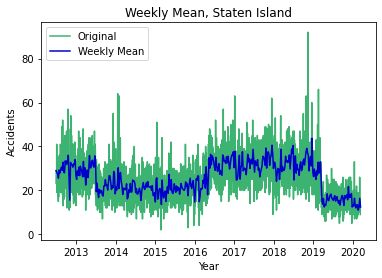

Test Statistic                  -2.271285
p-value                          0.181396
#Lags Used                       4.000000
Number of Observations Used    397.000000
dtype: float64

In [31]:
# Plot weekly data compared to daily
plt.plot(df_SI['Accidents_SI'],color='mediumseagreen', label='Original')
plt.plot(df_SI_wk_mean['Accidents_SI'], color='mediumblue', label='Weekly Mean')
plt.legend(loc='best')
plt.title('Weekly Mean, Staten Island')
plt.xlabel('Year')
plt.ylabel('Accidents')
plt.show(block=False)

# Dickey-Fuller test
test = adfuller(df_SI_wk_mean['Accidents_SI'][:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Based on the above Dickey-Fuller p-value, this data is not stationary. We will difference this data to attempt stationarity.

**Differencing**

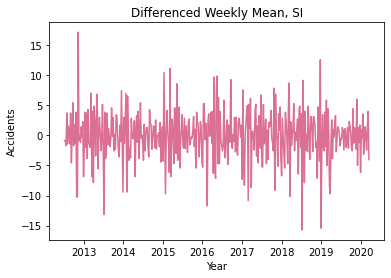

Test Statistic                -1.063407e+01
p-value                        5.125896e-19
#Lags Used                     6.000000e+00
Number of Observations Used    3.940000e+02
dtype: float64

In [32]:
# Difference data
diff = df_SI_wk_mean['Accidents_SI'].diff()

# Plot differenced data
plt.plot(diff, color='palevioletred', label='Differenced Rolling Weekly Mean')
plt.title('Differenced Weekly Mean, SI')
plt.xlabel('Year')
plt.ylabel('Accidents')
plt.show(block=False)

# Dickey-Fuller test
test = adfuller(diff[1:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Differencing once achieved stationarity, so we would expect our SARIMA model to have a d value of at least 1.

**ACF, PACF for Weekly Data**

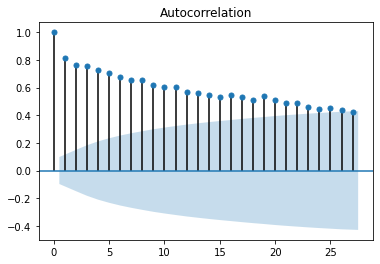

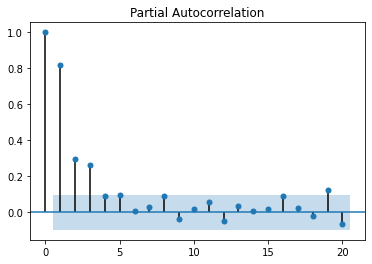

In [33]:
# ACF for weekly data
plot_acf(df_SI_wk_mean['Accidents_SI'], alpha=.05);

# PACF for weekly data
plot_pacf(df_SI_wk_mean['Accidents_SI'], alpha=.05, lags=20);

**Redo Train-Test Split for Weekly Data**

In [34]:
# Determine split point for 90%/10% train-test split
split_point = int(len(df_SI_wk_mean) * 0.9)
df_SI_wk_mean.iloc[split_point]

Accidents_SI    17.857143
Holiday          0.000000
Season           3.000000
Name: 2019-06-09 00:00:00, dtype: float64

In [35]:
# Train-test split
# Based on the above, 2019-06-06 will be the split point for our train and test sets

X = df_SI_wk_mean.index
y = df_SI_wk_mean['Accidents_SI']

train = df_SI_wk_mean.loc[:'2019-06-06']
test = df_SI_wk_mean.loc['2019-06-06':]

X_train, X_test = train.index , test.index
y_train, y_test = train['Accidents_SI'] , test['Accidents_SI']

**Grid Search for SARIMA Model**

In [36]:
# Determine best parameters for SARIMA model

# Define the p, d, and q parameters to take any value between 0 and 2
# Using smaller range due to many combinations
p = d = q = range(0,2)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, d, q triplets
# Choose s value of 52 because data is now weekly and a cycle is one year

pdqs = [(x[0],x[1],x[2], 52) for x in pdq]

# Run a grid search with pdq parameters calculated to see corresponding AIC scores
ans_SARIMA = []
for comb in pdq:
    for combs in tqdm_notebook(pdqs):
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans_SARIMA.append([comb, combs, output.aic])
            print('ARIMA {} x {}52 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 52)52 : AIC Calculated =3420.862317828535
ARIMA (0, 0, 0) x (0, 0, 1, 52)52 : AIC Calculated =2660.978254276538
ARIMA (0, 0, 0) x (0, 1, 0, 52)52 : AIC Calculated =2127.7392631748344
ARIMA (0, 0, 0) x (0, 1, 1, 52)52 : AIC Calculated =1743.2361361178635
ARIMA (0, 0, 0) x (1, 0, 0, 52)52 : AIC Calculated =2129.1368686237583
ARIMA (0, 0, 0) x (1, 0, 1, 52)52 : AIC Calculated =2117.8433631306584
ARIMA (0, 0, 0) x (1, 1, 0, 52)52 : AIC Calculated =1752.5447361713211
ARIMA (0, 0, 0) x (1, 1, 1, 52)52 : AIC Calculated =1744.6963919820714



ARIMA (0, 0, 1) x (0, 0, 0, 52)52 : AIC Calculated =3001.4889896271825
ARIMA (0, 0, 1) x (0, 0, 1, 52)52 : AIC Calculated =2371.5396267623355
ARIMA (0, 0, 1) x (0, 1, 0, 52)52 : AIC Calculated =1989.0468329555574
ARIMA (0, 0, 1) x (0, 1, 1, 52)52 : AIC Calculated =1604.6975328613667
ARIMA (0, 0, 1) x (1, 0, 0, 52)52 : AIC Calculated =1995.422918187088
ARIMA (0, 0, 1) x (1, 0, 1, 52)52 : AIC Calculated =1952.1039104653046
ARIMA (0, 0, 1) x (1, 1, 0, 52)52 : AIC Calculated =1633.1514875384446
ARIMA (0, 0, 1) x (1, 1, 1, 52)52 : AIC Calculated =1606.6967852162215



ARIMA (0, 1, 0) x (0, 0, 0, 52)52 : AIC Calculated =2082.394265821925
ARIMA (0, 1, 0) x (0, 0, 1, 52)52 : AIC Calculated =1765.335296366794
ARIMA (0, 1, 0) x (0, 1, 0, 52)52 : AIC Calculated =1942.511167617994
ARIMA (0, 1, 0) x (0, 1, 1, 52)52 : AIC Calculated =1518.0324511062115
ARIMA (0, 1, 0) x (1, 0, 0, 52)52 : AIC Calculated =1778.9546860505257
ARIMA (0, 1, 0) x (1, 0, 1, 52)52 : AIC Calculated =1766.7740666381912
ARIMA (0, 1, 0) x (1, 1, 0, 52)52 : AIC Calculated =1541.4327355291634
ARIMA (0, 1, 0) x (1, 1, 1, 52)52 : AIC Calculated =1527.246357634769



ARIMA (0, 1, 1) x (0, 0, 0, 52)52 : AIC Calculated =1988.0435935891394
ARIMA (0, 1, 1) x (0, 0, 1, 52)52 : AIC Calculated =1681.0191212107484
ARIMA (0, 1, 1) x (0, 1, 0, 52)52 : AIC Calculated =1845.7314013601335
ARIMA (0, 1, 1) x (0, 1, 1, 52)52 : AIC Calculated =1445.0018378628433
ARIMA (0, 1, 1) x (1, 0, 0, 52)52 : AIC Calculated =1700.2326430450657
ARIMA (0, 1, 1) x (1, 0, 1, 52)52 : AIC Calculated =1681.1713881266662
ARIMA (0, 1, 1) x (1, 1, 0, 52)52 : AIC Calculated =1471.855534620046
ARIMA (0, 1, 1) x (1, 1, 1, 52)52 : AIC Calculated =1451.796303274396



ARIMA (1, 0, 0) x (0, 0, 0, 52)52 : AIC Calculated =2086.577487208542
ARIMA (1, 0, 0) x (0, 0, 1, 52)52 : AIC Calculated =1778.7007512614769
ARIMA (1, 0, 0) x (0, 1, 0, 52)52 : AIC Calculated =1908.4112914872226
ARIMA (1, 0, 0) x (0, 1, 1, 52)52 : AIC Calculated =1498.8374551040658
ARIMA (1, 0, 0) x (1, 0, 0, 52)52 : AIC Calculated =1777.9291134590385
ARIMA (1, 0, 0) x (1, 0, 1, 52)52 : AIC Calculated =1779.9284912737103
ARIMA (1, 0, 0) x (1, 1, 0, 52)52 : AIC Calculated =1518.663456827427
ARIMA (1, 0, 0) x (1, 1, 1, 52)52 : AIC Calculated =1500.813512633704



ARIMA (1, 0, 1) x (0, 0, 0, 52)52 : AIC Calculated =1994.200701644709
ARIMA (1, 0, 1) x (0, 0, 1, 52)52 : AIC Calculated =1688.2004675356088
ARIMA (1, 0, 1) x (0, 1, 0, 52)52 : AIC Calculated =1851.1496651464736
ARIMA (1, 0, 1) x (0, 1, 1, 52)52 : AIC Calculated =1451.4007052814645
ARIMA (1, 0, 1) x (1, 0, 0, 52)52 : AIC Calculated =1701.6100397157315
ARIMA (1, 0, 1) x (1, 0, 1, 52)52 : AIC Calculated =1688.4135414339994
ARIMA (1, 0, 1) x (1, 1, 0, 52)52 : AIC Calculated =1473.1192299150098
ARIMA (1, 0, 1) x (1, 1, 1, 52)52 : AIC Calculated =1453.3260065502996



ARIMA (1, 1, 0) x (0, 0, 0, 52)52 : AIC Calculated =2035.6549814624072
ARIMA (1, 1, 0) x (0, 0, 1, 52)52 : AIC Calculated =1723.8810736740184
ARIMA (1, 1, 0) x (0, 1, 0, 52)52 : AIC Calculated =1901.0958780269702
ARIMA (1, 1, 0) x (0, 1, 1, 52)52 : AIC Calculated =1485.2238325252952
ARIMA (1, 1, 0) x (1, 0, 0, 52)52 : AIC Calculated =1723.4777461629096
ARIMA (1, 1, 0) x (1, 0, 1, 52)52 : AIC Calculated =1725.4679905720454
ARIMA (1, 1, 0) x (1, 1, 0, 52)52 : AIC Calculated =1507.302373922766
ARIMA (1, 1, 0) x (1, 1, 1, 52)52 : AIC Calculated =1492.8980459219451



ARIMA (1, 1, 1) x (0, 0, 0, 52)52 : AIC Calculated =1985.1905583108912
ARIMA (1, 1, 1) x (0, 0, 1, 52)52 : AIC Calculated =1678.008235653429
ARIMA (1, 1, 1) x (0, 1, 0, 52)52 : AIC Calculated =1841.6425600505333
ARIMA (1, 1, 1) x (0, 1, 1, 52)52 : AIC Calculated =1443.9632648068446
ARIMA (1, 1, 1) x (1, 0, 0, 52)52 : AIC Calculated =1682.7322661953604
ARIMA (1, 1, 1) x (1, 0, 1, 52)52 : AIC Calculated =1678.1112979846498
ARIMA (1, 1, 1) x (1, 1, 0, 52)52 : AIC Calculated =1463.3315310539356
ARIMA (1, 1, 1) x (1, 1, 1, 52)52 : AIC Calculated =1450.3925957265378



In [37]:
# Find parameters with minimal AIC value
SARIMA_AIC = pd.DataFrame(ans_SARIMA, columns=['pdq', 'pdqs', 'aic'])
SARIMA_AIC.sort_values(by='aic', ascending=True, inplace=True)
SARIMA_AIC[:10]

,pdq,pdqs,aic
59,"(1, 1, 1)","(0, 1, 1, 52)",1443.963265
27,"(0, 1, 1)","(0, 1, 1, 52)",1445.001838
63,"(1, 1, 1)","(1, 1, 1, 52)",1450.392596
43,"(1, 0, 1)","(0, 1, 1, 52)",1451.400705
31,"(0, 1, 1)","(1, 1, 1, 52)",1451.796303
47,"(1, 0, 1)","(1, 1, 1, 52)",1453.326007
62,"(1, 1, 1)","(1, 1, 0, 52)",1463.331531
30,"(0, 1, 1)","(1, 1, 0, 52)",1471.855535
46,"(1, 0, 1)","(1, 1, 0, 52)",1473.119230
51,"(1, 1, 0)","(0, 1, 1, 52)",1485.223833


**Narrowing Down Parameter Values**

Observe lowest 10 AIC score parameter values to determine best model. Make sure p values are significant, and observe RMSEs to determind best overall model.

In [38]:
for index,row in SARIMA_AIC[:10].iterrows():
    mod = sm.tsa.statespace.SARIMAX(y_train,
                                    order=SARIMA_AIC['pdq'][index],
                                    seasonal_order=SARIMA_AIC['pdqs'][index],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    mod_fit = mod.fit()
    print(mod_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                       Accidents_SI   No. Observations:                  362
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -717.982
Date:                            Thu, 18 Feb 2021   AIC                           1443.963
Time:                                    14:50:02   BIC                           1458.128
Sample:                                07-01-2012   HQIC                          1449.661
                                     - 06-02-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1613      0.087      1.857      0.063      -0.009       0.332
ma.L1         -0.7341      0.061   

                                     SARIMAX Results                                      
Dep. Variable:                       Accidents_SI   No. Observations:                  362
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood                -721.663
Date:                            Thu, 18 Feb 2021   AIC                           1453.326
Time:                                    14:50:34   BIC                           1471.052
Sample:                                07-01-2012   HQIC                          1460.455
                                     - 06-02-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9787      0.018     54.745      0.000       0.944       1.014
ma.L1         -0.6091      0.048   

Based on the above, we see that the following parameters yield significant p-values:

(0,1,1)x(0,1,1,52)

(1,0,1)x(0,1,1,52)

(0,1,1)x(1,1,1,52)

(1,1,1)x(1,1,0,52)

(0,1,1)x(1,1,0,52)

(1,0,1)x(1,1,0,52)

(1,1,0)x(0,1,1,52)

We wil observe RMSE and AIC values for these parameters to determine our best working model.

In [39]:
# For loop to apply RMSE function to significant parameters
for (pdq,pdqs) in [((0,1,1),(0,1,1,52)),((1,0,1),(0,1,1,52)),((0,1,1),(1,1,1,52)),
                 ((1,1,1),(1,1,0,52)),((0,1,1),(1,1,0,52)),((1,0,1),(1,1,0,52)),
                  ((1,1,0),(0,1,1,52))]:
    mod = sm.tsa.statespace.SARIMAX(y_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    mod_fit = mod.fit()
    mod_pred = mod_fit.predict(start='2019-06-06', end='2020-03-13',dynamic=False)
    print(pdq, 'x', pdqs,': RMSE: ', RMSE(mod_pred), 'AIC: ', mod_fit.aic)
    

(0, 1, 1) x (0, 1, 1, 52) : RMSE:  2.236525537186472 AIC:  1445.0018378628433
(1, 0, 1) x (0, 1, 1, 52) : RMSE:  5.782983329248169 AIC:  1451.4007052814645
(0, 1, 1) x (1, 1, 1, 52) : RMSE:  2.4314766573454083 AIC:  1451.796303274396
(1, 1, 1) x (1, 1, 0, 52) : RMSE:  3.0644819623919135 AIC:  1463.3315310539356
(0, 1, 1) x (1, 1, 0, 52) : RMSE:  2.9645709497497794 AIC:  1471.855534620046
(1, 0, 1) x (1, 1, 0, 52) : RMSE:  5.362441277911673 AIC:  1473.1192299150098
(1, 1, 0) x (0, 1, 1, 52) : RMSE:  2.148235808800881 AIC:  1485.2238325252952


Based on its best RMSE value and only slightly worse AIC value, we see that the last option gives us our best SARIMA model. We will define this as our SARIMA model and compare it to our baseline ARIMA model.

In order to compare RMSEs between daily and weekly data, we will divide RMSEs by the range of the number of accidents in each dataset. A smaller RMSE-to-range ratio will tell us which is our better RMSE. These will be labeled "Adjusted RMSE".

In [41]:
SARIMA = sm.tsa.statespace.SARIMAX(y_train,
                                   order=(1,1,0),
                                   seasonal_order=(0,1,1,52),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
SARIMA_fit = SARIMA.fit()
SARIMA_pred = SARIMA_fit.predict(start='2019-06-06', end='2020-03-13',dynamic=False)
print('SARIMA RMSE: ', RMSE(SARIMA_pred))
print('Adjusted SARIMA RMSE: ',
      RMSE(SARIMA_pred)/(df_SI_wk_mean['Accidents_SI'].max()-df_SI_wk_mean['Accidents_SI'].min()))
print('SARIMA AIC: ', SARIMA_fit.aic)

print('ARIMA RMSE: ', base_RMSE)
print('Adjusted ARIMA RMSE: ',
      base_RMSE/(df_SI['Accidents_SI'].max()-df_SI['Accidents_SI'].min()))
print('ARIMA AIC: ', base_AIC)

SARIMA RMSE:  2.148235808800881
Adjusted SARIMA RMSE:  0.06566659677557278
SARIMA AIC:  1485.2238325252952
ARIMA RMSE:  7.768997848118968
Adjusted ARIMA RMSE:  0.08632219831243297
ARIMA AIC:  17477.371509562086


Based on the above, our SARIMA model performs better than our ARIMA model.

## Model #4: Incorporating Both Exogenous and Seasonal Variables: SARIMAX Model

Attempting a SARIMAX model incorporating both holiday and season variables as exogenous data did not yield any usable models. The p-value associated with "season" were consistently extremely high. Therefore re-ran only incorporating holiday as the exogenous variable. Other exogenous variables used in the earlier ARIMAX model are not replicable on a weekly basis.

**Grid Search**

In [42]:
# Determine best parameters for SARIMAX model
# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, d, q triplets
# Choose s value of 365 because data is daily and a cycle is one year

pdqs = [(x[0],x[1],x[2], 52) for x in pdq]

# Run a grid search with pdq parameters calculated to see corresponding AIC scores
ans_SARIMAX = []
for comb in pdq:
    for combs in tqdm_notebook(pdqs):
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            exog = train.iloc[:,1],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans_SARIMAX.append([comb, combs, output.aic])
            print('SARIMAX {} x {}52 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
            

SARIMAX (0, 0, 0) x (0, 0, 0, 52)52 : AIC Calculated =3365.2377802989686
SARIMAX (0, 0, 0) x (0, 0, 1, 52)52 : AIC Calculated =2642.126618819375
SARIMAX (0, 0, 0) x (0, 1, 0, 52)52 : AIC Calculated =2127.9065131436064
SARIMAX (0, 0, 0) x (0, 1, 1, 52)52 : AIC Calculated =1743.4631000670797
SARIMAX (0, 0, 0) x (1, 0, 0, 52)52 : AIC Calculated =2129.4108499727477
SARIMAX (0, 0, 0) x (1, 0, 1, 52)52 : AIC Calculated =2125.1249077794623
SARIMAX (0, 0, 0) x (1, 1, 0, 52)52 : AIC Calculated =1752.6927413403673
SARIMAX (0, 0, 0) x (1, 1, 1, 52)52 : AIC Calculated =1744.88741802407



SARIMAX (0, 0, 1) x (0, 0, 0, 52)52 : AIC Calculated =3000.5436420707856
SARIMAX (0, 0, 1) x (0, 0, 1, 52)52 : AIC Calculated =2372.1021318527364
SARIMAX (0, 0, 1) x (0, 1, 0, 52)52 : AIC Calculated =1985.794912582491
SARIMAX (0, 0, 1) x (0, 1, 1, 52)52 : AIC Calculated =1598.5984054341404
SARIMAX (0, 0, 1) x (1, 0, 0, 52)52 : AIC Calculated =1992.044882085878
SARIMAX (0, 0, 1) x (1, 0, 1, 52)52 : AIC Calculated =1974.3173974432639
SARIMAX (0, 0, 1) x (1, 1, 0, 52)52 : AIC Calculated =1627.5729292124608
SARIMAX (0, 0, 1) x (1, 1, 1, 52)52 : AIC Calculated =1600.6210847881578



SARIMAX (0, 1, 0) x (0, 0, 0, 52)52 : AIC Calculated =2057.9535782409725
SARIMAX (0, 1, 0) x (0, 0, 1, 52)52 : AIC Calculated =1744.0534506563981
SARIMAX (0, 1, 0) x (0, 1, 0, 52)52 : AIC Calculated =1939.4866053687974
SARIMAX (0, 1, 0) x (0, 1, 1, 52)52 : AIC Calculated =1504.101877745762
SARIMAX (0, 1, 0) x (1, 0, 0, 52)52 : AIC Calculated =1755.827262554379
SARIMAX (0, 1, 0) x (1, 0, 1, 52)52 : AIC Calculated =1745.9141218807354
SARIMAX (0, 1, 0) x (1, 1, 0, 52)52 : AIC Calculated =1533.34969546405
SARIMAX (0, 1, 0) x (1, 1, 1, 52)52 : AIC Calculated =1511.992435316595



SARIMAX (0, 1, 1) x (0, 0, 0, 52)52 : AIC Calculated =1964.9123811384857
SARIMAX (0, 1, 1) x (0, 0, 1, 52)52 : AIC Calculated =1662.7054729060787
SARIMAX (0, 1, 1) x (0, 1, 0, 52)52 : AIC Calculated =1843.2840093995085
SARIMAX (0, 1, 1) x (0, 1, 1, 52)52 : AIC Calculated =1436.804929823365
SARIMAX (0, 1, 1) x (1, 0, 0, 52)52 : AIC Calculated =1681.5521925863575
SARIMAX (0, 1, 1) x (1, 0, 1, 52)52 : AIC Calculated =1664.119875239055
SARIMAX (0, 1, 1) x (1, 1, 0, 52)52 : AIC Calculated =1467.1825409005914
SARIMAX (0, 1, 1) x (1, 1, 1, 52)52 : AIC Calculated =1443.1254674199783



SARIMAX (1, 0, 0) x (0, 0, 0, 52)52 : AIC Calculated =2062.3817057788438
SARIMAX (1, 0, 0) x (0, 0, 1, 52)52 : AIC Calculated =1755.4701045558718
SARIMAX (1, 0, 0) x (0, 1, 0, 52)52 : AIC Calculated =1905.9851730266766
SARIMAX (1, 0, 0) x (0, 1, 1, 52)52 : AIC Calculated =1486.5387339463607
SARIMAX (1, 0, 0) x (1, 0, 0, 52)52 : AIC Calculated =1755.3831980762839
SARIMAX (1, 0, 0) x (1, 0, 1, 52)52 : AIC Calculated =1757.3585994407629
SARIMAX (1, 0, 0) x (1, 1, 0, 52)52 : AIC Calculated =1511.6989945909518
SARIMAX (1, 0, 0) x (1, 1, 1, 52)52 : AIC Calculated =1498.7646716706545



SARIMAX (1, 0, 1) x (0, 0, 0, 52)52 : AIC Calculated =1971.4564198150567
SARIMAX (1, 0, 1) x (0, 0, 1, 52)52 : AIC Calculated =1669.1680526075565
SARIMAX (1, 0, 1) x (0, 1, 0, 52)52 : AIC Calculated =1848.7060515950243
SARIMAX (1, 0, 1) x (0, 1, 1, 52)52 : AIC Calculated =1442.8588205632873
SARIMAX (1, 0, 1) x (1, 0, 0, 52)52 : AIC Calculated =1682.9191724846944
SARIMAX (1, 0, 1) x (1, 0, 1, 52)52 : AIC Calculated =1670.643975418788
SARIMAX (1, 0, 1) x (1, 1, 0, 52)52 : AIC Calculated =1468.3663153755715
SARIMAX (1, 0, 1) x (1, 1, 1, 52)52 : AIC Calculated =1448.9630759045351



SARIMAX (1, 1, 0) x (0, 0, 0, 52)52 : AIC Calculated =2004.4049403523816
SARIMAX (1, 1, 0) x (0, 0, 1, 52)52 : AIC Calculated =1698.7756662117995
SARIMAX (1, 1, 0) x (0, 1, 0, 52)52 : AIC Calculated =1899.1088146385928
SARIMAX (1, 1, 0) x (0, 1, 1, 52)52 : AIC Calculated =1473.4713855380355
SARIMAX (1, 1, 0) x (1, 0, 0, 52)52 : AIC Calculated =1698.825312827943
SARIMAX (1, 1, 0) x (1, 0, 1, 52)52 : AIC Calculated =1700.7747935743278
SARIMAX (1, 1, 0) x (1, 1, 0, 52)52 : AIC Calculated =1501.1654071922117
SARIMAX (1, 1, 0) x (1, 1, 1, 52)52 : AIC Calculated =1479.318220545622



SARIMAX (1, 1, 1) x (0, 0, 0, 52)52 : AIC Calculated =1964.0801610491621
SARIMAX (1, 1, 1) x (0, 0, 1, 52)52 : AIC Calculated =1661.149780681042
SARIMAX (1, 1, 1) x (0, 1, 0, 52)52 : AIC Calculated =1839.0839250984652
SARIMAX (1, 1, 1) x (0, 1, 1, 52)52 : AIC Calculated =1434.9990713183422
SARIMAX (1, 1, 1) x (1, 0, 0, 52)52 : AIC Calculated =1665.7882862188712
SARIMAX (1, 1, 1) x (1, 0, 1, 52)52 : AIC Calculated =1662.3054594458577
SARIMAX (1, 1, 1) x (1, 1, 0, 52)52 : AIC Calculated =1458.013261775608
SARIMAX (1, 1, 1) x (1, 1, 1, 52)52 : AIC Calculated =1440.9090871128283



In [43]:
# Find parameters with minimal AIC value
SARIMAX_AIC = pd.DataFrame(ans_SARIMAX, columns=['pdq', 'pdqs', 'aic'])
SARIMAX_AIC.sort_values(by='aic', ascending=True, inplace=True)
SARIMAX_AIC[:10]

,pdq,pdqs,aic
59,"(1, 1, 1)","(0, 1, 1, 52)",1434.999071
27,"(0, 1, 1)","(0, 1, 1, 52)",1436.804930
63,"(1, 1, 1)","(1, 1, 1, 52)",1440.909087
43,"(1, 0, 1)","(0, 1, 1, 52)",1442.858821
31,"(0, 1, 1)","(1, 1, 1, 52)",1443.125467
47,"(1, 0, 1)","(1, 1, 1, 52)",1448.963076
62,"(1, 1, 1)","(1, 1, 0, 52)",1458.013262
30,"(0, 1, 1)","(1, 1, 0, 52)",1467.182541
46,"(1, 0, 1)","(1, 1, 0, 52)",1468.366315
51,"(1, 1, 0)","(0, 1, 1, 52)",1473.471386


**Narrowing Down Model Parameters**

Observe lowest 10 AIC score parameter values to determine best model. Make sure p values are significant, and observe RMSEs to determind best overall model.

In [44]:
for index,row in SARIMAX_AIC[:10].iterrows():
    mod = sm.tsa.statespace.SARIMAX(y_train,
                                    exog = train.iloc[:,1],
                                    order=SARIMAX_AIC['pdq'][index],
                                    seasonal_order=SARIMAX_AIC['pdqs'][index],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    
    
    mod_fit = mod.fit()
    print(mod_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                       Accidents_SI   No. Observations:                  362
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -712.500
Date:                            Thu, 18 Feb 2021   AIC                           1434.999
Time:                                    14:59:02   BIC                           1452.705
Sample:                                07-01-2012   HQIC                          1442.121
                                     - 06-02-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday       -2.1694      0.743     -2.918      0.004      -3.627      -0.712
ar.L1          0.1868      0.092   

                                     SARIMAX Results                                      
Dep. Variable:                       Accidents_SI   No. Observations:                  362
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -716.563
Date:                            Thu, 18 Feb 2021   AIC                           1443.125
Time:                                    14:59:29   BIC                           1460.832
Sample:                                07-01-2012   HQIC                          1450.248
                                     - 06-02-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday       -2.2798      0.789     -2.891      0.004      -3.826      -0.734
ma.L1         -0.6362      0.047   

                                      SARIMAX Results                                      
Dep. Variable:                        Accidents_SI   No. Observations:                  362
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 52)   Log Likelihood                -729.183
Date:                             Thu, 18 Feb 2021   AIC                           1468.366
Time:                                     14:59:59   BIC                           1486.112
Sample:                                 07-01-2012   HQIC                          1475.503
                                      - 06-02-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday       -1.9601      0.837     -2.341      0.019      -3.601      -0.319
ar.L1          0.9869      

Based on the above, we see that the following parameters have significant p values:

(1,1,1)x(0,1,1,52)

(0,1,1)x(0,1,1,52)

(1,1,1)x(1,1,1,52)

(1,0,1)x(0,1,1,52)

(0,1,1)x(1,1,1,52)

(1,0,1)x(1,1,1,52)

(1,1,1)x(1,1,0,52)

(0,1,1)x(1,1,0,52)

(1,0,1)x(1,1,0,52)

(1,1,0)x(0,1,1,52)


We will observe these models' RMSE and AIC score to determine which is our best SARIMAX model.

**Determine Best SARIMAX Model**

In [45]:
# For loop to apply RMSE function to significant parameters
for (pdq,pdqs) in [((1,1,1),(0,1,1,52)),((0,1,1),(0,1,1,52)),((1,1,1),(1,1,1,52)),((1,0,1),(0,1,1,52)),
                  ((0,1,1),(1,1,1,52)),((1,0,1),(1,1,1,52)),((1,1,1),(1,1,0,52)),((0,1,1),(1,1,0,52)),
                  ((1,0,1),(1,1,0,52)),((1,1,0),(0,1,1,52))]:
    mod = sm.tsa.statespace.SARIMAX(y_train,
                                    exog = train.iloc[:,1],
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    mod_fit = mod.fit()
    mod_pred = mod_fit.predict(start='2019-06-06', end='2020-03-13', exog = test.iloc[:,1],
                               dynamic=False)
    print(pdq, 'x', pdqs,': RMSE: ', RMSE(mod_pred), 'AIC: ', mod_fit.aic)
    

(1, 1, 1) x (0, 1, 1, 52) : RMSE:  2.1205136657398045 AIC:  1434.9990713183422
(0, 1, 1) x (0, 1, 1, 52) : RMSE:  2.164344679231873 AIC:  1436.804929823365
(1, 1, 1) x (1, 1, 1, 52) : RMSE:  2.4576427007204438 AIC:  1440.9090871128283
(1, 0, 1) x (0, 1, 1, 52) : RMSE:  5.968955904172776 AIC:  1442.8588205632873
(0, 1, 1) x (1, 1, 1, 52) : RMSE:  2.284339706962739 AIC:  1443.1254674199783
(1, 0, 1) x (1, 1, 1, 52) : RMSE:  5.523901888998928 AIC:  1448.9630759045351
(1, 1, 1) x (1, 1, 0, 52) : RMSE:  3.026464552703205 AIC:  1458.013261775608
(0, 1, 1) x (1, 1, 0, 52) : RMSE:  2.9049948207628344 AIC:  1467.1825409005914
(1, 0, 1) x (1, 1, 0, 52) : RMSE:  5.569543302309762 AIC:  1468.3663153755715
(1, 1, 0) x (0, 1, 1, 52) : RMSE:  2.0628194296791666 AIC:  1473.4713855380355


Based on the above, the last model is our best SARIMAX model. It has the best RMSE, and only slightly worse AIC score.

Now we will define this as our SARIMAX model and compare to our SARIMA model.

In [46]:
SARIMAX = sm.tsa.statespace.SARIMAX(y_train,
                                    exog = train.iloc[:,1],
                                    order=(1,1,0),
                                    seasonal_order=(0,1,1,52),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
SARIMAX_fit = SARIMAX.fit()
SARIMAX_pred = SARIMAX_fit.predict(start='2019-06-06', end='2020-03-13', exog = test.iloc[:,1],
                                   dynamic=False)

SARIMAX_RMSE = RMSE(SARIMAX_pred)
SARIMAX_adj_RMSE = SARIMAX_RMSE/(df_SI_wk_mean['Accidents_SI'].max()-df_SI_wk_mean['Accidents_SI'].min())
SARIMAX_AIC = SARIMAX_fit.aic

print('SARIMA RMSE: ', RMSE(SARIMA_pred))
print('Adjusted SARIMA RMSE: ',
      RMSE(SARIMA_pred)/(df_SI_wk_mean['Accidents_SI'].max()-df_SI_wk_mean['Accidents_SI'].min()))
print('SARIMA AIC: ', SARIMA_fit.aic)

print('SARIMAX RMSE: ', SARIMAX_RMSE)
print('Adjusted SARIMAX RMSE: ', SARIMAX_adj_RMSE)
print('SARIMAX AIC: ', SARIMAX_AIC)

SARIMA RMSE:  2.148235808800881
Adjusted SARIMA RMSE:  0.06566659677557278
SARIMA AIC:  1485.2238325252952
SARIMAX RMSE:  2.0628194296791666
Adjusted SARIMAX RMSE:  0.06305561575438501
SARIMAX AIC:  1473.4713855380355


We see from the above that our SARIMAX model is better than our SARIMA model, both in terms of RMSE and AIC.

**Of our models until this point, the SARIMAX model is our best model**

# Final Model Analysis

Now that we have determined our best model based on RMSE and AIC, let's dig into it a bit more deeply.

**Model Metrics**

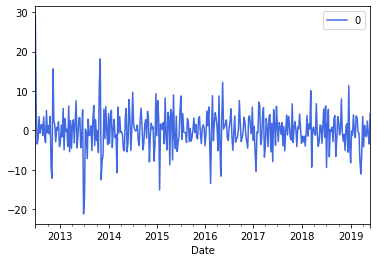

In [47]:
# Visualize residuals/error
residuals = pd.DataFrame(SARIMAX_fit.resid)
residuals.plot(color='royalblue')
plt.show();

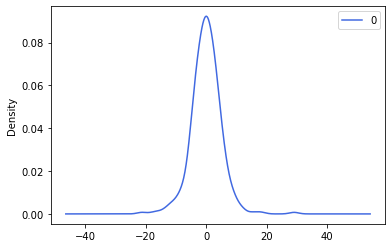

In [48]:
# Check for linearity
residuals = pd.DataFrame(SARIMAX_fit.resid)
residuals.plot(kind='kde', color='royalblue')
plt.show()


Based on the first graph above, we see residuals centered and concentrated at 0, though with more variance than is ideal. With a mean at approximately 0, the second graph shows that our model is mostly linear.

**Test Predictions**

We know that this ARIMA model yielded our best test predictions from its RMSE and AIC score, but let's visualize our predictions compared to the true data.

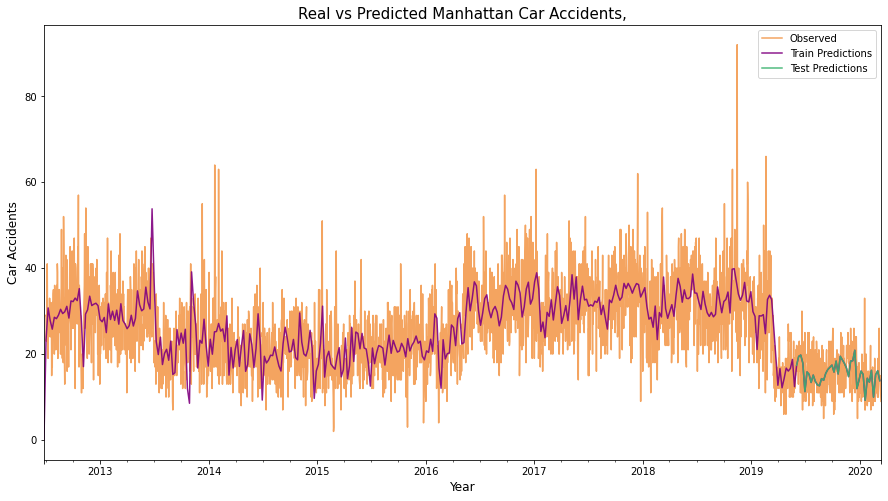

In [49]:
# Plot real vs predicted values
fix,ax = plt.subplots(figsize=(15, 8))

# Plot observed values
ax = df_SI['Accidents_SI'].plot(label='Observed', color='sandybrown')

# Plot predicted train values
SARIMAX_pred_train = SARIMAX_fit.predict(start='2012-07-01', end='2020-03-13', exog = test.iloc[:,1], dynamic=False)
SARIMAX_pred_train.plot(ax=ax, label='Train Predictions', alpha=0.9, color='purple')

# Plot predicted values
SARIMAX_pred.plot(ax=ax, label='Test Predictions', alpha=0.9, color='mediumseagreen')

# Set axes labels and title
ax.set_xlabel('Year', size=12)
ax.set_ylabel('Car Accidents',size=12)
ax.set_title('Real vs Predicted Manhattan Car Accidents,', size=15)

plt.legend()
plt.show()

# Forecasting

Now that we see how our data performed on our train and test data, it is time to apply it to the future.

## July 1, 2021 through the end of 2021

As discussed in the EDA notebook, we will use our current model to predict accident numbers starting on July 1, 2021, assuming a 25% decrease from our model predictions.

In [50]:
# Create df including all Brooklyn data, not only pre-Covid like we've been using for modeling
df_SI_total = df_TS.drop(columns = ['Injuries', 'Deaths','Accidents_Bx', 'Accidents_Man', 'Accidents_Qns', 'Accidents_Bkln',
                               'Accidents_Total'])

In [51]:
# Create exog data for forecast through 6/30/2022--whether or not there is a holiday that week
exog = pd.DataFrame(pd.date_range(start='2019-06-09', periods=160, freq='W'))
exog.rename(columns={0:'Date'},inplace=True)
exog.set_index('Date',inplace=True)


exog['Holiday'] = 0

# July 4th
exog.loc['2019-06-30']['Holiday'] = 1
exog.loc['2020-06-28']['Holiday'] = 1
exog.loc['2021-07-04']['Holiday'] = 1
exog.loc['2022-06-26']['Holiday'] = 1

# Xmas Eve, Xmas
exog.loc['2019-12-22']['Holiday'] = 1
exog.loc['2020-12-20']['Holiday'] = 1
exog.loc['2021-12-19']['Holiday'] = 1

# New Years Eve, New Years Day
exog.loc['2019-12-29']['Holiday'] = 1
exog.loc['2020-12-27']['Holiday'] = 1
exog.loc['2021-12-26']['Holiday'] = 1

# Thanksgiving, Post-Thanksgiving
exog.loc['2019-11-24']['Holiday'] = 1
exog.loc['2020-11-22']['Holiday'] = 1
exog.loc['2021-11-21']['Holiday'] = 1

# MLK Day
exog.loc['2020-01-19']['Holiday'] = 1
exog.loc['2021-01-17']['Holiday'] = 1
exog.loc['2022-01-16']['Holiday'] = 1

# President's Day
exog.loc['2020-02-16']['Holiday'] = 1
exog.loc['2021-02-14']['Holiday'] = 1
exog.loc['2022-02-20']['Holiday'] = 1

# Easter
exog.loc['2020-04-12']['Holiday'] = 1
exog.loc['2021-04-04']['Holiday'] =1
exog.loc['2022-04-17']['Holiday'] = 1

# Memorial Day
exog.loc['2020-05-24']['Holiday'] = 1
exog.loc['2021-05-30']['Holiday'] = 1
exog.loc['2022-05-29']['Holiday'] = 1

# Labor Day
exog.loc['2019-09-01']['Holiday'] = 1
exog.loc['2020-09-06']['Holiday'] = 1
exog.loc['2021-09-05']['Holiday'] = 1

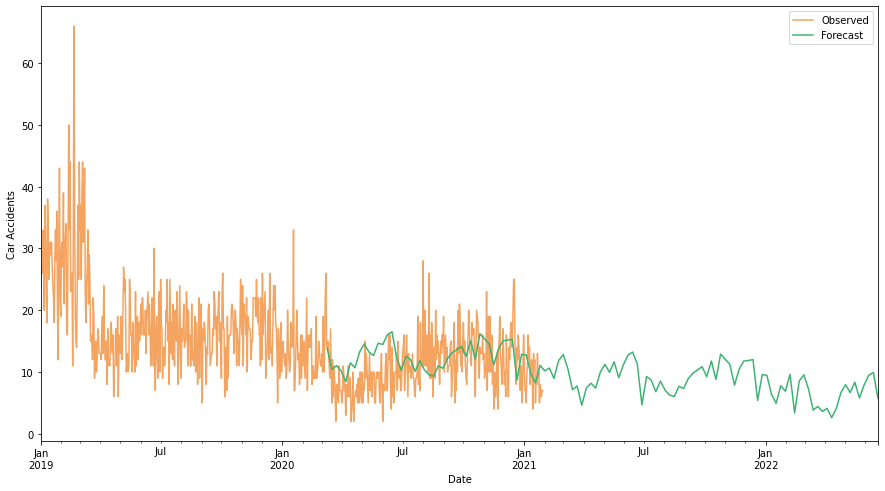

In [52]:
# Generate forcast from 3/14/20-6/30/2022 (120 weeks, 838 days)
forecast = SARIMAX_fit.forecast(steps=160,exog=exog['Holiday'])
pred_values = pd.DataFrame(forecast)
pred_values = pred_values[0]
pred_values

# Plot forecast
fix,ax = plt.subplots(figsize=(15, 8))
ax = df_SI_total['Accidents_SI']['2019-01-01':].plot(label='Observed', color='sandybrown')
pred_values['2020-03-14':].plot(ax=ax, label='Forecast',color='mediumseagreen')

ax.set_xlabel('Date')
ax.set_ylabel('Car Accidents')

plt.legend()
plt.show()

The above shows us what our predictions would have been through the end of 2021, if it hadn't been for the COVID-19 pandemic. Now let's look at what our actual predictions are, given what we do know about te pandemic and related predictions discussed earlier.

Staten Island accidents was much less impact by the pandemic than the other boroughs were. As we can see above, non-altered predictions also end up lower than current data. We will therefore not alter these projections and instead apply them starting on February 28 instead of July 1.

In [79]:
# Create df of adjusted COVID predictions
# Starting week of 2/28/21, 95% of original predictions
TS_pred_cov = pred_values['2021-02-28':]

# Create linear data connecting last known data point and predicted data linearly
# Create df for connection data
connection = pd.DataFrame(pd.date_range(start='2021-01-30', end='2021-02-28', freq='W'))
connection['Date'] = pd.DataFrame(pd.date_range(start='2021-01-30', end='2021-02-28', freq='W'))

# Find how much the accident count will rise each day
# There are just over 4 weeks between 1/29/21 and 2/28/21 (weekly values)
weekly_interval=(TS_pred_cov['2021-02-28'] - df_SI_total['Accidents_SI']['2021-01-29'])/4.2

# Add daily interval to each date in connection df
connection_forecasts = []
i = df_SI_total['Accidents_SI']['2021-01-29']
for num in range(0,5):
    i+=weekly_interval
    connection_forecasts.append(i)

# Add list of forecasts to connection df
connection['Forecast'] = connection_forecasts


# Make date index of connection df
connection.set_index('Date', inplace=True)
connection.drop(columns=0,inplace=True)


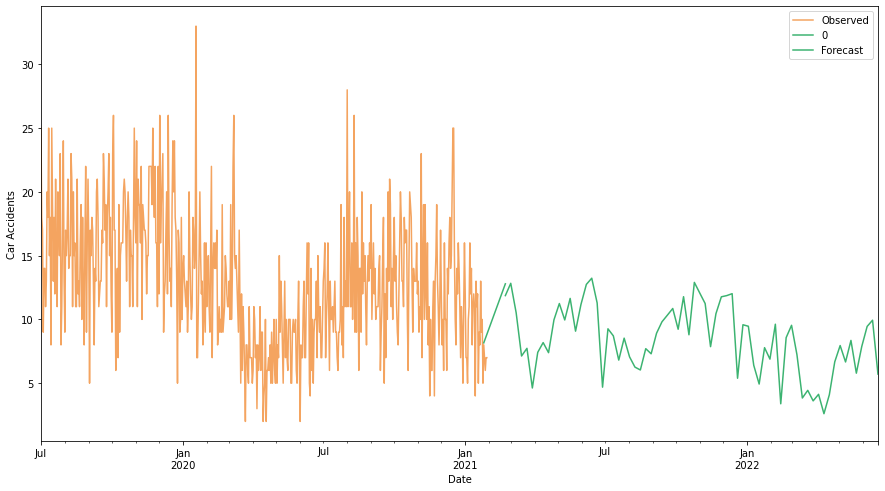

In [143]:
fix,ax = plt.subplots(figsize=(15, 8))

# Plot known data
ax = df_SI_total['Accidents_SI']['2019-07-01':].plot(label='Observed', color='sandybrown')

# Plot predicted data based on model, starting 7/1/20, 95% of model prediction
TS_pred_cov.plot(ax=ax, label='Forecast',color='mediumseagreen')

# Plot linear connection
connection.plot(ax=ax, color='mediumseagreen')

ax.set_xlabel('Date')
ax.set_ylabel('Car Accidents')

plt.legend()
plt.show()

The above shows our best predictions for car accidents in Staten Island with an ARIMA-type model. In a separate notebook, we will create a Facebook Prophet model and compare it to this one.

# Export Data

In our FB Prophet notebook, we saw that our SARIMAX model was the best one for our Manhattan data. We will therefore export data from this model to use on our Streamlit dashboard.

In [133]:
# Set daily predictions as their weekly mean

# Connection df
connection_daily = pd.DataFrame(pd.date_range(start='2021-01-31', end='2021-02-27', freq='D'))
connection_daily.rename(columns={0:'Date'},inplace=True)
connection_daily.set_index('Date',inplace=True)

daily_forecast = [8]
for index,row in connection.iterrows():
    daily_forecast.extend([connection.loc[index]['Forecast']] * 7)

del daily_forecast[-8:]

connection_daily['Forecast'] = daily_forecast

# Predictions df
pred_daily = pd.DataFrame(pd.date_range(start='2021-02-28', end='2022-06-30', freq='D'))
pred_daily.rename(columns={0:'Date'},inplace=True)
pred_daily.set_index('Date',inplace=True)

TS_pred_cov = pd.DataFrame(data = TS_pred_cov)

daily_pred = []
for index,row in TS_pred_cov.iterrows():
    daily_pred.extend([TS_pred_cov.loc[index][0]] * 7)

del daily_pred[-2:]

pred_daily['Forecast'] = daily_pred
            

In [136]:
# Create one df combining known and predicted accident frequencies
# Round forecasts to integers 
data_preds_SI = pd.concat([df_SI_total['Accidents_SI'],round(connection_daily['Forecast']),round(pred_daily['Forecast'])])
data_preds_SI.to_csv('Data/data_preds_SI.csv')